In [1]:
import pygeostat as gs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [165]:
gs.Parameters['plotting.sigfigs'] = 2
gs.Parameters['plotting.scatter_plot.stat_xy'] = (0.9,0.95)
gs.Parameters['plotting.scatter_plot.s'] = 2
gs.PlotStyle['figure.figsize'] = (8, 8)

<h1 style='color:#1B127A;'>
Data Generation
</h1>

<h1 style='color:#1B127A;'>
Simple krigining or normal equations or linear regression
</h1>

Simple kriging is equivalent to solving multiple linear regression for each data configuration (i.e. for each missing data location). In both cases, a linear model is proposed to estimate a missing variable. The weights and bias/shift are calculated to minimize the expected squared error (i.e. error variance). It can be shown that weights of a linear model that minimizes the squared error are calculated using the covariance between conditioning variables (features) and between conditioning variables and the response variable (i.e. label).

The main difference is that in case of linear regression, the equally sampled observations of multiple variables are available and can be used to calculate the covariances and intern the wights and bias. However, in kriging (spatial interpolation), the spatial arrangement and the euclidean distance between data locations is provided. In this context, the covariance is the auto-covariance as it is the covariance between one variables and the spatially lagged bversion of the same variable (or another variable). Each data location is regarded a a random variable and the covariance is provided by a variogram model that is a statistical measure of variability as a function of Euclidean distance.

In geostatistics, experimental variograms are calculated and assumed to be representative of a stationary domain. A linear model of regionalization/co-regionalization can be used to model the variobaility/variogram along all directions. The variogram is a model of spatial variability and can be used to derive the covariance as a function of spatial distance.


The example in this notebook is used to show how simple krigining can be used to provide a linear estimator using a multivariate Gaussian data set. The main feature of a multivariate Gaussian distribution is that it is fully quantified by a covariance matrix and a mean vector and the conditional means are given by normal equations. The main objective is to evaluate the simple kriging estimator variance and show how it is expected to be lower than the response variable variance.

<h2 style='color:#5177F9;'>
Simple kriging equation
</h2>

Simple kriging is known as best linear unbiased estimate (blue). 

$z^*(u_0) = \sum \lambda_{\alpha} z(u_{\alpha}) + \lambda_0 \;\;\;\; \alpha = 1, ..., n$

Note that $z^*(u_0)$ is an estimate and correspondingly, the linear combination random variables $Z(u_{\alpha})$ is its self a random variable called estimator:

$Z^*(u_0) = \sum \lambda_{\alpha} Z(u_{\alpha}) + \lambda_0 \;\;\;\; \alpha = 1, ..., n$

where $u$ denotes the location of a random variable in the spatial coordinate system. While the actual error $z(u_0)-z^*(u_0)$ is usually unknown, the expected values of the error random variable i.e. $Z(u_0)-Z^*(u_0)$ can be calculated.

$E\{Z(u_0)-Z^*(u_0)\} = E\{Z(u_0)\} - E\{Z^*(u_0\} = m_0 - \lambda_0 - \sum \lambda_{\alpha}m_{\alpha}$

In order to have an unbiased estimator, we want the expected error to be zero

$E\{Z(u_0)-Z^*(u_0)\} = 0 \rightarrow  \;\; \lambda_0 = m_0 - \sum \lambda_{\alpha} m_{\alpha}$

Thus the linear estimator can be written as:

$Z^*(u_0)- m_0= \sum \lambda_{\alpha} (Z(u_{\alpha}) - m_{\alpha})  \;\;\;\; \alpha = 1, ..., n$

In order to solve Simple kriging, either the mean is constant and known everywhere (i.e. first order stationarity) or the mean is know at each data location (e.g. a trend model informed by local averaging or secondary data).

The weights are then found based on minimizing the error variance i.e. $E\{(Z_0-Z^*_0)^2\}$. 

$\sum_{\beta=1}^{n} \lambda_{\beta} Cov(u_{\alpha}-u_{\beta}) =  Cov(u_{\alpha}-u_{0})\;\;\;\; \alpha = 1, ..., n$

Considering $Z_0-Z^*_0$ as the error random variable, the $E\{(Z_0-Z^*_0)^2\}$ is regarded as expected squared error that is the error variance considering the unbiased estimate i.e. $E\{Z_0-Z^*_0\} = 0$. The corresponding minimized error variance, may be written as:

$\sigma^2_{sk} = C_{00} - \sum \lambda_{\alpha}C_{\alpha 0} \alpha = 1, ..., n$

where $C_{\alpha 0}$ is the covariance between unsampled location and the data locations i.e. $Cov(u_0 - u_{\alpha})$. Note that unlike regular linear regression there are no multiple observations of variables available to infer the covariance or minimize a loss function to find the weights and bias. Instead, random variables and expected values are used to form the kriging equations. The final solution is the same; however, in kriging covariance is informed by a statistical average of the entire domain i.e. a covariance function or a variogram model.  

<h2 style='color:#5177F9;'>
Example class
</h2>

A simple python class is defined to implement sampling, kriging equations, analysis and comparison with multiple linear regression

In [246]:
class KrigingExample():
    
    """Create a simplified example using a 4 variables multivariate Gaussiand distribution
    """
    
    def __init__(self, mean, cov, n_sample):
    
        cov_inv = np.linalg.inv(cov)
        n_mv_samples = np.random.multivariate_normal(mean, cov, n_sample).T

        self.data=pd.DataFrame(dtype=np.float32)
        variables = []
        for i, variable in enumerate(n_mv_samples):
            var_name = 'Variable%i'%(i+1)
            variables.append(var_name)
            self.data[var_name] = variable
        
        # assign conditioning variables 
        self.conditioning_vars = self.data.columns[0:-1]
        self.response_var = self.data.columns[-1]
        print('Conditining variables (features):', ', '.join(conditioning_vars))
        print('Response variable (label):', ', '.join([response_var]))

        print(self.data.head())
        
        self.__setup_kriging()
        
        frac = min(1000/len(self.data), 1.0)
        data_vis = self.data.sample(frac=frac)
        fig= gs.scatter_plots(data_vis)
    
    def __setup_kriging(self):
        """Get kriging covriance matrices and mean vectors
        """
        self.K = cov[:-1,:-1] # Cij 
        self.k = cov[-1,:-1].reshape(K.shape[0],1)
        self.C00= cov[-1,-1] # lag zero covariance or variance of the response variable
        self.Z_mean = mean[:-1].reshape(K.shape[0],1)
        self.Z0_mean = mean[-1]
        
        
    def get_kriging_weights(self):
        """
        Get the kriging weights and also return the equivalent bias value
        """
        self.lambdas = np.matmul(self.k.T, np.linalg.inv(self.K)) # trasnpose of lamdas
        print('kriging weights are:', self.lambdas.flatten())
        self.bias = self.Z0_mean - np.matmul(self.lambdas, self.Z_mean)
        print('kriging bias is: {}'.format(self.bias.flatten()))
        
    def get_regression_weights(self):
        X = self.data.values[:,0:-1]
        y = self.data.values[:,-1]
        X = np.append(np.ones((len(self.data),1)),X, axis=1)
        result =  np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)), X.T),y)
        print('Regression weights are: ', result[1:].flatten())
        print('Regression bias is: ', result[0].flatten())

    def get_kriging_mean(self, Z):
        """Get the kriging estimate at an unsmpled location
        Z: array of conditining values (features)
        """
        Z = np.array(Z).reshape(len(Z),1)
        result = np.matmul(self.lambdas, (Z-self.Z_mean)) + self.Z0_mean
        return result.flatten()[0]
    
    def get_kriging_variance(self):
        """Get the minimized expected squared error i.e. error variance aka simple kriging variance
        """
        result = self.C00 - np.matmul(self.lambdas,self.k)
        return result.flatten()[0]
    
    def estimate_analysis(self):
        """Get the estimate analysis and comparison vs actual data
        """
        estimate = self.data[self.conditioning_vars].apply(lambda x: self.get_kriging_mean(x), axis=1)
        
        print('Response variable variance: {:.2f}'.format(np.var(self.data[self.response_var])))
        print('Kriging estimate variance:  {:.2f}'.format(np.var(estimate)))
        print('Kriging error varaince:     {:.2f}'.format(self.get_kriging_variance()))
        
        ax = gs.histogram_plot(estimate, icdf=True)
        gs.histogram_plot(self.data[response_var], icdf=True, ax=ax, color='r', stat_xy=(0.05,0.95), stat_ha='left')

<h2 style='color:#5177F9;'>
Example 1
</h2>

In the first example, a multivariate Gaussian distribution is sampled to generate data with known covariances and simple kriging equations are used to calculate the kriging weights. Multiple linear regression weights and bias value are also calculate to compare it against simple kriging.

Note that only a fraction of data are use in the scatter plots to minimize processing time required to render the plots.

Conditining variables (features): Variable1, Variable2, Variable3
Response variable (label): Variable4
   Variable1  Variable2  Variable3  Variable4
0  -1.094490  -0.915219   0.835992  -0.327295
1   1.849331   1.404819  -1.860512   0.770085
2   0.866046   0.656888  -0.186994   0.177776
3  -1.623269  -1.158840   0.505412  -0.696476
4   1.448685   1.213068  -1.104005   0.410367


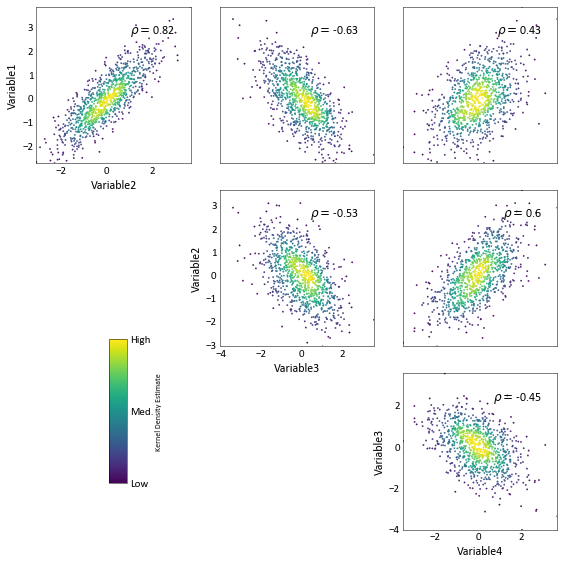

In [247]:
n_sample = 100000
mean = np.array([0, 0, 0, 0])
cov = np.array([[1, 0.8, -0.6, 0.4], [0.8, 1, -0.5, 0.6], [-0.6, -0.5, 1, -0.4], [0.4, 0.6, -0.4, 1]])  # diagonal covariance
krig_example = KrigingExample(mean, cov, n_sample)

**Kriging Weights and bias**

With kriging that is in spatial context, we don't have multiple observations of the variables. Instead each location is deemed to be a random variable. Based on collected spatial data within a domain that is deemed to be stationary, mean, variance and covariance are calculated as statistical measures representative of the domain.

In [248]:
krig_example.get_kriging_weights()

kriging weights are: [-0.34782609  0.76521739 -0.22608696]
kriging bias is: [0.]


**Linear regression**

With the example data that contains multiple equally sampled observations, we can use the actual multiple linear regression and compare it with simple kriging. As mentioned previously, the main difference is that linear regression relies on using data matrix (n_observation x n_dimensions) to solve the equations while in kriging, each data location along with the unsampled location are treated as random variables. The final equations rely on a covariance function that is informed by a stationary variogram model.

In [249]:
krig_example.get_regression_weights()

Regression weights are:  [-0.34754111  0.76273557 -0.2279288 ]
Regression bias is:  [-0.00138464]


**Smoothness of Kriging**

Kriging estimator is smoother than actual data and the difference in variance is equal to the kriging variance. The analysis below uses the numerical results to show that such relationship (based on kriging equations) is valid.

Response variable variance: 1.00
Kriging estimate variance:  0.41
Kriging error varaince:     0.59


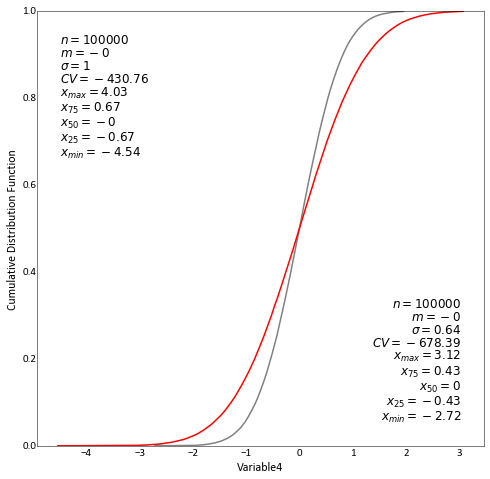

In [250]:
krig_example.estimate_analysis()

<h2 style='color:#5177F9;'>
Example 2
</h2>

In this example, the variables have non-zero mean value and the variance is not necessarily 1.0. Note that the covariance matrix needs to be positive definite.

Conditining variables (features): Variable1, Variable2, Variable3
Response variable (label): Variable4
   Variable1  Variable2  Variable3  Variable4
0   6.061389   3.145413  -2.961047   2.882376
1   5.215211   2.306100  -0.910202   5.729722
2   4.943383   2.038441  -1.209787   3.602713
3   5.601657   2.849638  -0.469021   4.204660
4   4.134499   2.013305   0.579728   4.348887


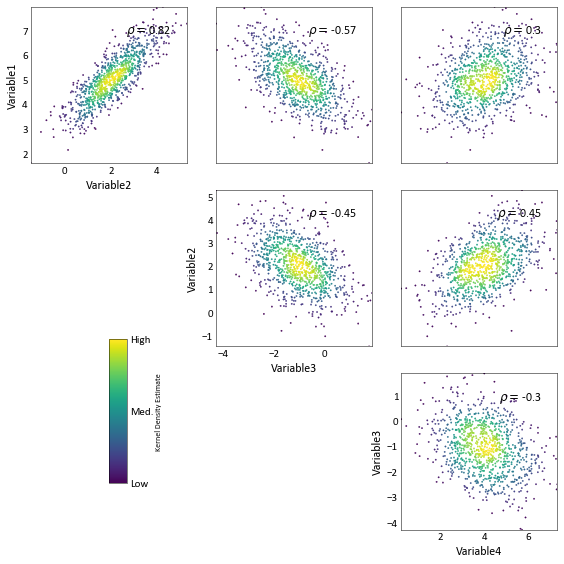

In [260]:
n_sample = 100000
mean = np.array([5, 2, -1, 4])
cov = np.array([[0.95, 0.8, -0.6, 0.4], [0.8, 1, -0.5, 0.6], [-0.6, -0.5, 1, -0.4], [0.4, 0.6, -0.4, 1.5]])  # diagonal covariance
krig_example = KrigingExample(mean, cov, n_sample)

In [261]:
krig_example.get_kriging_weights()

kriging weights are: [-0.41558442  0.81038961 -0.24415584]
kriging bias is: [4.21298701]


In [262]:
krig_example.get_regression_weights()

Regression weights are:  [-0.42405971  0.81485524 -0.24826519]
Regression bias is:  [4.24316836]


Response variable variance: 1.50
Kriging estimate variance:  0.42
Kriging error varaince:     1.08


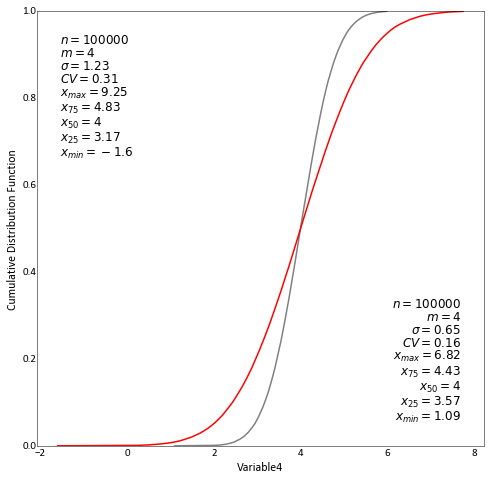

In [263]:
krig_example.estimate_analysis()